# Python/AIML Project: EasyVisa

## Problem Statement

### Context:

Business communities in the United States are facing high demand for human resources, but one of the constant challenges is identifying and attracting the right talent, which is perhaps the most important element in remaining competitive. Companies in the United States look for hard-working, talented, and qualified individuals both locally as well as abroad.

The Immigration and Nationality Act (INA) of the US permits foreign workers to come to the United States to work on either a temporary or permanent basis. The act also protects US workers against adverse impacts on their wages or working conditions by ensuring US employers' compliance with statutory requirements when they hire foreign workers to fill workforce shortages. The immigration programs are administered by the Office of Foreign Labor Certification (OFLC).

OFLC processes job certification applications for employers seeking to bring foreign workers into the United States and grants certifications in those cases where employers can demonstrate that there are not sufficient US workers available to perform the work at wages that meet or exceed the wage paid for the occupation in the area of intended employment.

### Objective:

In FY 2016, the OFLC processed 775,979 employer applications for 1,699,957 positions for temporary and permanent labor certifications. This was a nine percent increase in the overall number of processed applications from the previous year. The process of reviewing every case is becoming a tedious task as the number of applicants is increasing every year.

The increasing number of applicants every year calls for a Machine Learning based solution that can help in shortlisting the candidates having higher chances of VISA approval. OFLC has hired the firm EasyVisa for data-driven solutions. You as a data  scientist at EasyVisa have to analyze the data provided and, with the help of a classification model:

* Facilitate the process of visa approvals.
* Recommend a suitable profile for the applicants for whom the visa should be certified or denied based on the drivers that significantly influence the case status.

### Data Description

The data contains the different attributes of employee and the employer. The detailed data dictionary is given below.

* case_id: ID of each visa application
* continent: Information of continent the employee
* education_of_employee: Information of education of the employee
* has_job_experience: Does the employee has any job experience? Y= Yes; N = No
* requires_job_training: Does the employee require any job training? Y = Yes; N = No
* no_of_employees: Number of employees in the employer's company
* yr_of_estab: Year in which the employer's company was established
* region_of_employment: Information of foreign worker's intended region of employment in the US.
* prevailing_wage:  Average wage paid to similarly employed workers in a specific occupation in the area of intended employment. The purpose of the prevailing wage is to ensure that the foreign worker is not underpaid compared to other workers offering the same or similar service in the same area of employment.
* unit_of_wage: Unit of prevailing wage. Values include Hourly, Weekly, Monthly, and Yearly.
* full_time_position: Is the position of work full-time? Y = Full Time Position; N = Part Time Position
* case_status:  Flag indicating if the Visa was certified or denied

## Importing necessary libraries

In [6]:
# installing libraries with specified versions
!pip install numpy == 1.25.2 pandas == 1.5.3 scikit-learn == 1.5.2 matplotlib == 3.7.1 seaborn == 0.13.1 xgboost == 2.0.3 -q --user
!pip install xgboost --user
!pip install xgboost

zsh:1: = not found


In [8]:
import warnings
warnings.filterwarnings("ignore")

# import libraries for handling data
import numpy as np
import pandas as pd

# set display options to show all columns and limit rows
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

# import library to split data
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# import libraries for data resampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# import libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# import different ensemble classifiers
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier
)

# import decision tree classifier
from sklearn.tree import DecisionTreeClassifier

# import xgboost classifier
from xgboost import XGBClassifier

# import libraries for model evaluation
from sklearn import metrics
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

# import library to tune model hyperparameters
from sklearn.model_selection import RandomizedSearchCV

## Import Dataset

In [10]:
visa = pd.read_csv('/Users/shreyamenon/Documents/EasyVisa.csv') # read data from file
data = visa.copy() # copying data set to keep original data the same

## Overview of the Dataset

#### View the first and last 5 rows of the dataset

In [13]:
# view top 5 rows of data
print(data.head())

# view last 5 rows of data
print(data.tail())

# view dimensions of data
data.shape

# display basic information about data
data.info()

# check for duplicate entries in data
data.duplicated().sum()

  case_id continent education_of_employee has_job_experience  \
0  EZYV01      Asia           High School                  N   
1  EZYV02      Asia              Master's                  Y   
2  EZYV03      Asia            Bachelor's                  N   
3  EZYV04      Asia            Bachelor's                  N   
4  EZYV05    Africa              Master's                  Y   

  requires_job_training  no_of_employees  yr_of_estab region_of_employment  \
0                     N            14513         2007                 West   
1                     N             2412         2002            Northeast   
2                     Y            44444         2008                 West   
3                     N               98         1897                 West   
4                     N             1082         2005                South   

   prevailing_wage unit_of_wage full_time_position case_status  
0         592.2029         Hour                  Y      Denied  
1       83425.65

0

This code helps me explore the dataset by showing the first and last five rows, its shape, and basic details. The dataset has 25,480 rows and 12 columns, with no missing values across numerical and categorical features. Checking for duplicates returns 0, meaning there are no duplicate rows. Overall, the data looks clean and ready for further analysis.

## Exploratory Data Analysis (EDA)

#### Let's check the statistical summary of the data

In [17]:
# print statistical summary of data
data.describe()

,no_of_employees,yr_of_estab,prevailing_wage
count,25480.000000,25480.000000,25480.000000
mean,5667.043210,1979.409929,74455.814592
std,22877.928848,42.366929,52815.942327
min,-26.000000,1800.000000,2.136700
25%,1022.000000,1976.000000,34015.480000
50%,2109.000000,1997.000000,70308.210000
75%,3504.000000,2005.000000,107735.512500
max,602069.000000,2016.000000,319210.270000


This statistical summary gives me insights into the dataset’s numerical columns. The no_of_employees column has a minimum value of -26, which suggests incorrect or inconsistent data that may need cleaning. The yr_of_estab column ranges from 1800 to 2016, which seems unrealistic for modern companies and may need further verification. The prevailing_wage varies widely, from 2.14 dollars to 319,210 dollars, with a high standard deviation, indicating significant differences in wages. Overall, I see potential data inconsistencies that I may need to address before further analysis.

#### Fixing the negative values in number of employees columns

In [20]:
# check negative values in no_of_employees column
print(data.loc[data["no_of_employees"] < 0].shape)

# convert values in no_of_employees column to positive
data["no_of_employees"] = abs(data["no_of_employees"])

(33, 12)


This code checks for negative values in the no_of_employees column and finds negative values, 33 rows and 12 columns in this case. Since negative employee counts don’t make sense, the code corrects them by taking their absolute values. This ensures that all employee counts are positive, cleaning the data for further analysis.

#### Let's check the count of each unique category in each of the categorical variables

In [23]:
# get list of categorical columns
categorical_columns = list(data.select_dtypes("object").columns)

# print count of each unique value in categorical columns
for column in categorical_columns:
    print(data[column].value_counts())
    print("-" * 50)

# check number of unique values in case_id column
data["case_id"].nunique()

# drop case_id column from data
data.drop(["case_id"], axis = 1, inplace = True)

case_id
EZYV01       1
EZYV16995    1
EZYV16993    1
EZYV16992    1
EZYV16991    1
            ..
EZYV8492     1
EZYV8491     1
EZYV8490     1
EZYV8489     1
EZYV25480    1
Name: count, Length: 25480, dtype: int64
--------------------------------------------------
continent
Asia             16861
Europe            3732
North America     3292
South America      852
Africa             551
Oceania            192
Name: count, dtype: int64
--------------------------------------------------
education_of_employee
Bachelor's     10234
Master's        9634
High School     3420
Doctorate       2192
Name: count, dtype: int64
--------------------------------------------------
has_job_experience
Y    14802
N    10678
Name: count, dtype: int64
--------------------------------------------------
requires_job_training
N    22525
Y     2955
Name: count, dtype: int64
--------------------------------------------------
region_of_employment
Northeast    7195
South        7017
West         6586
Midwest      

This code identifies categorical columns, counts unique values for each, and removes the case_id column since it has only unique values and is not useful for analysis. The dataset contains categorical variables such as continent, education, job experience, and visa status. Most employees are from Asia, have at least a bachelor’s degree, and the majority of applications are certified. The dataset appears well-structured for further analysis.

### Univariate Analysis

In [26]:
def histogram_boxplot(data, feature, figsize=(15, 10), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (15,10))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [27]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

#### Observations on education of employee

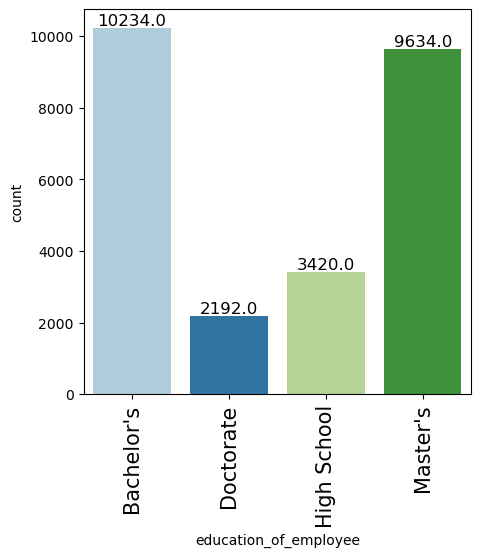

In [29]:
labeled_barplot(data, "education_of_employee")

This bar plot shows the distribution of employee education levels. Most employees have either a bachelor's or master's degree, while fewer have a doctorate or only a high school education. This suggests that higher education levels are common among applicants, which could be an important factor in visa approvals.

#### Observations on region of employment

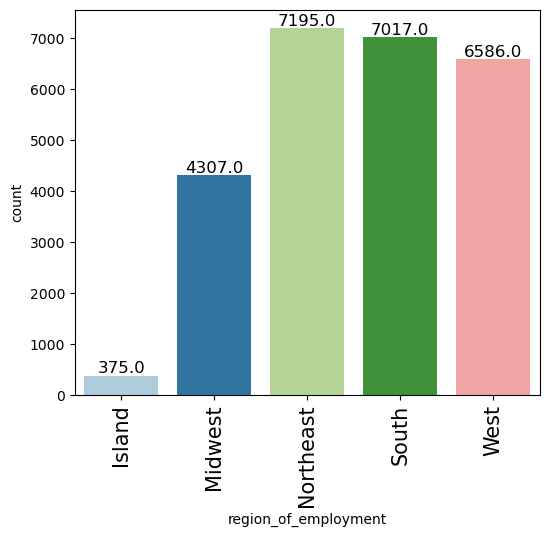

In [32]:
labeled_barplot(data, "region_of_employment")

This bar plot shows the distribution of employment across different regions. The northeast has the highest number of employees, followed closely by the south and west. The midwest has fewer employees, and the island region has the lowest count. This suggests that visa applications are more concentrated in certain regions, possibly due to job availability and demand.

#### Observations on job experience

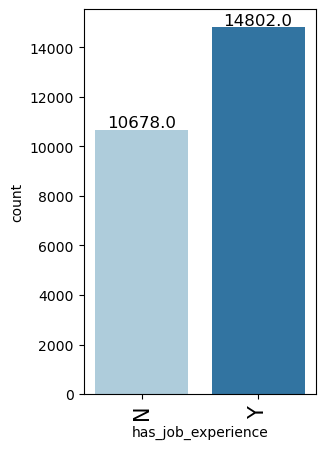

In [35]:
labeled_barplot(data, "has_job_experience")

This bar plot shows the distribution of job experience among applicants. More employees have job experience compared to those who do not. This suggests that prior work experience may be a common factor among visa applicants, potentially influencing approval rates.

#### Observations on case status

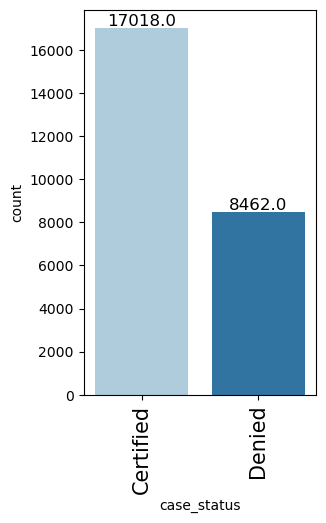

In [38]:
labeled_barplot(data, "case_status")

This bar plot shows the distribution of visa application outcomes. More applications are certified than denied, indicating a higher approval rate. Understanding the factors that influence certification could help identify key drivers of visa approval.

### Bivariate Analysis

**Creating functions that will help us with further analysis.**

In [42]:
### function to plot distributions wrt target


def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
        stat="density",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
        stat="density",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

In [43]:
def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 5))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

#### Those with higher education may want to travel abroad for a well-paid job. Let's find out if education has any impact on visa certification

case_status            Certified  Denied    All
education_of_employee                          
All                        17018    8462  25480
Bachelor's                  6367    3867  10234
High School                 1164    2256   3420
Master's                    7575    2059   9634
Doctorate                   1912     280   2192
------------------------------------------------------------------------------------------------------------------------


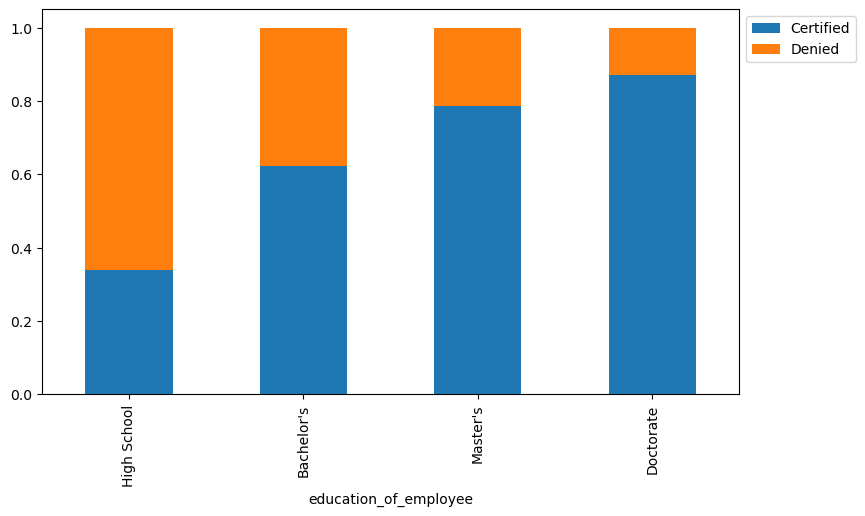

In [45]:
stacked_barplot(data, "education_of_employee", "case_status")

This stacked bar plot shows the relationship between education level and visa certification. Applicants with higher education, such as a master's or doctorate, have a higher certification rate compared to those with a high school diploma. High school graduates have the highest proportion of denials, suggesting that education level may play a role in visa approval.

#### Lets' similarly check for the continents and find out how the visa status vary across different continents.

case_status    Certified  Denied    All
continent                              
All                17018    8462  25480
Asia               11012    5849  16861
North America       2037    1255   3292
Europe              2957     775   3732
South America        493     359    852
Africa               397     154    551
Oceania              122      70    192
------------------------------------------------------------------------------------------------------------------------


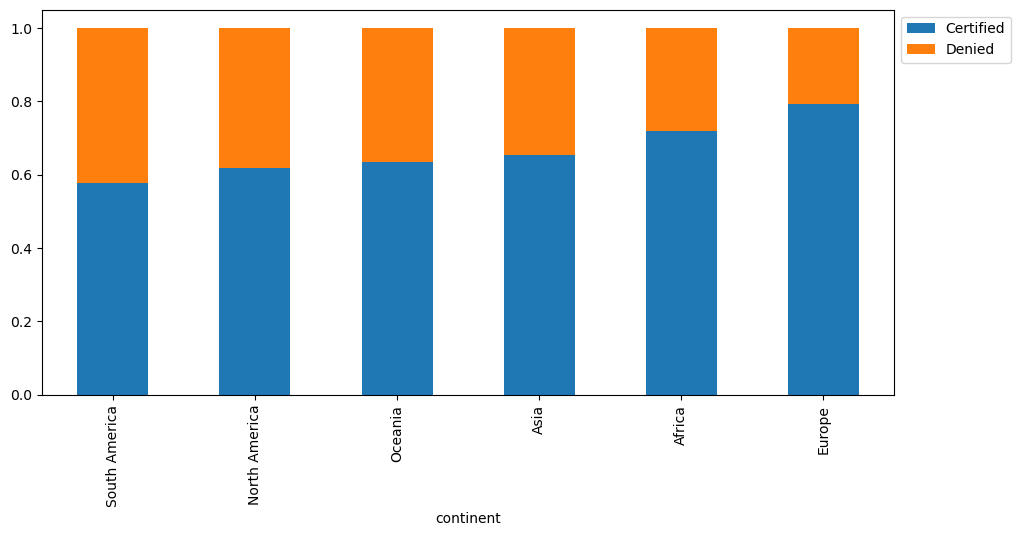

In [48]:
stacked_barplot(data, "continent", "case_status")

This stacked bar plot shows the visa certification rates by continent. Europe and Africa have the highest certification rates, while South America has the lowest. Asia has the highest number of applicants, but a significant portion of them are denied. This suggests that visa approval rates may vary by region, possibly due to differences in job demand, applicant qualifications, or policy factors.

#### Experienced professionals might look abroad for opportunities to improve their lifestyles and career development. Let's see if having work experience has any influence over visa certification

has_job_experience      N      Y    All
case_status                            
All                 10678  14802  25480
Certified            5994  11024  17018
Denied               4684   3778   8462
------------------------------------------------------------------------------------------------------------------------


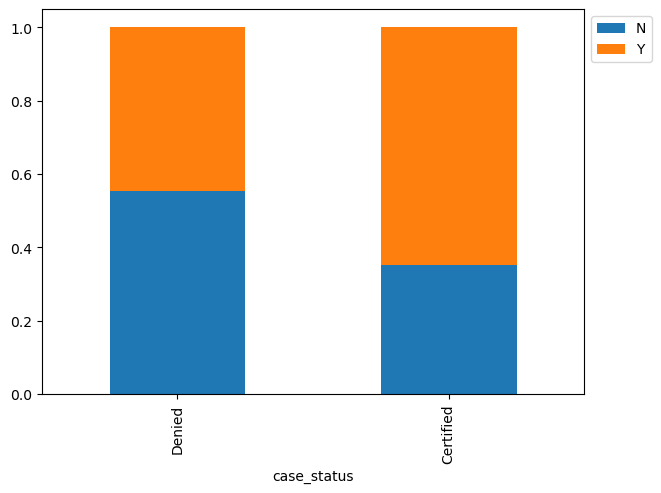

In [51]:
stacked_barplot(data, "case_status", "has_job_experience")

This stacked bar plot shows the relationship between work experience and visa certification. Applicants with job experience have a higher certification rate compared to those without experience. A significant portion of applicants without experience have their visas denied, suggesting that prior work experience may improve the chances of visa approval.

#### Checking if the prevailing wage is similar across all the regions of the US

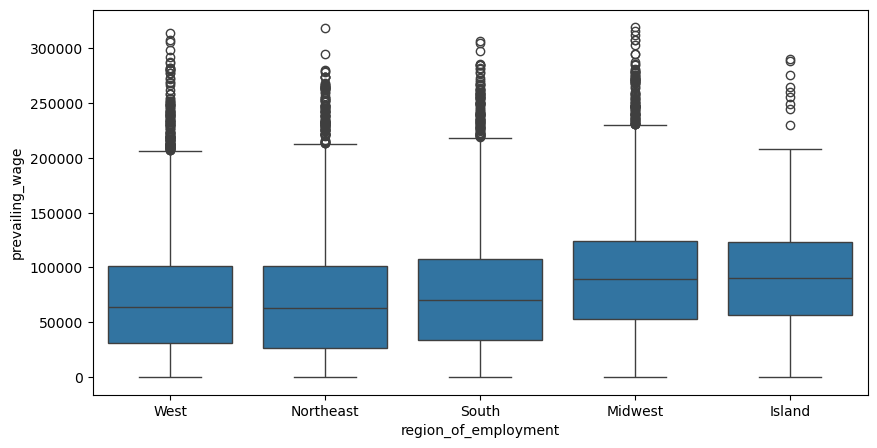

In [54]:
plt.figure(figsize = (10, 5))
sns.boxplot(data = data, x = "region_of_employment", y = "prevailing_wage")
plt.show()

This boxplot compares prevailing wages across different US employment regions. The median wages appear similar, but there is considerable variation within each region. All regions have a large number of outliers, suggesting that some jobs offer significantly higher wages than others. Overall, while the wage distribution is fairly consistent, there are differences in wage dispersion across regions.

#### The US government has established a prevailing wage to protect local talent and foreign workers. Let's analyze the data and see if the visa status changes with the prevailing wage

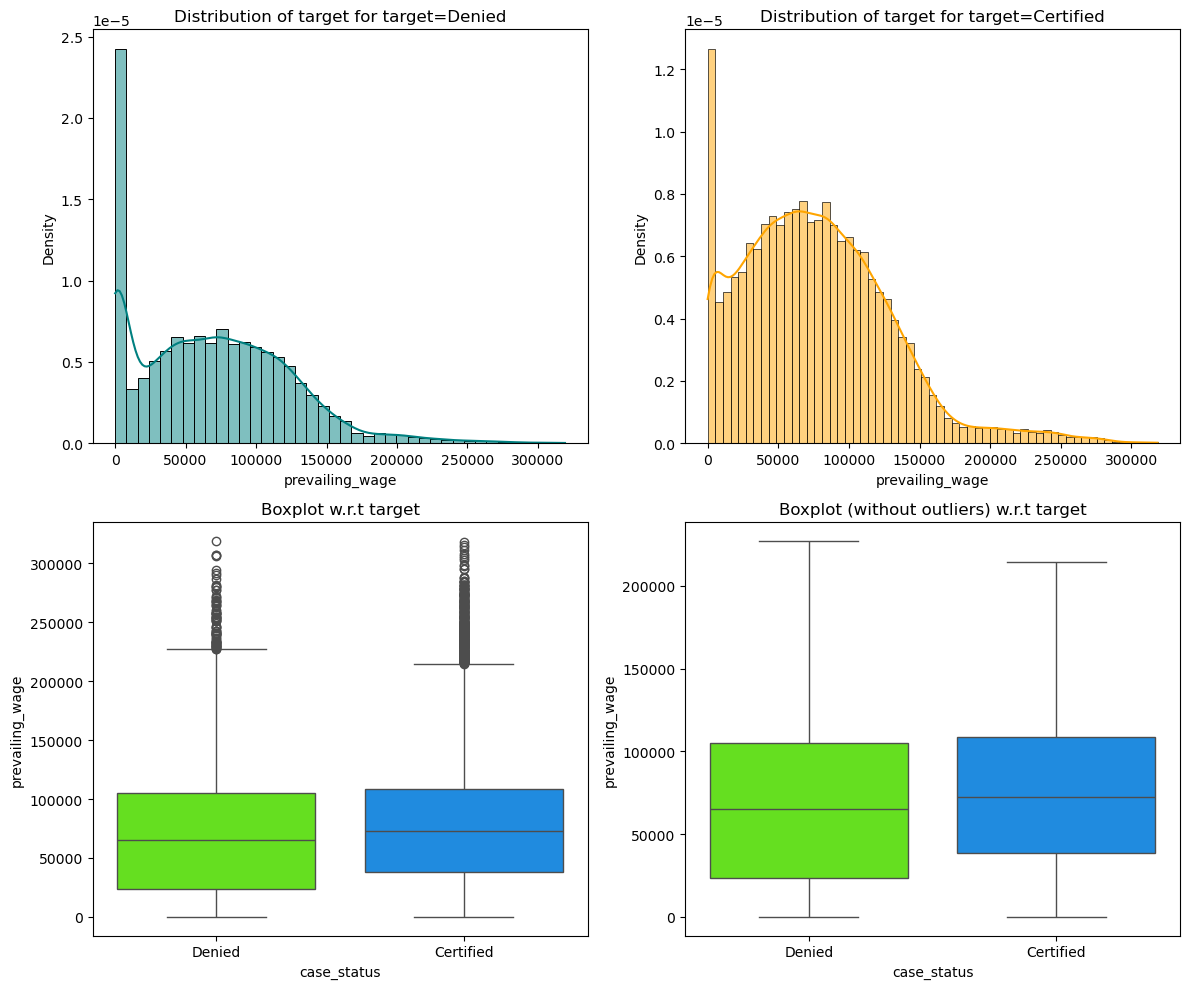

In [57]:
# analyzing how visa status changes with prevailing wage
distribution_plot_wrt_target(data, "prevailing_wage", "case_status")

I'm exploring how prevailing wages relate to visa approval. The first set of visualizations compares wage distributions for denied and certified visa cases. I can see that while both groups have similar wage ranges, certified cases tend to have slightly higher wages on average. The second set of boxplots confirms this trend, showing overlapping wage distributions but a slightly higher median wage for certified cases. There are also many outliers, suggesting significant variation in wages across applications.

#### The prevailing wage has different units (Hourly, Weekly, etc). Let's find out if it has any impact on visa applications getting certified.

case_status   Certified  Denied    All
unit_of_wage                          
All               17018    8462  25480
Year              16047    6915  22962
Hour                747    1410   2157
Week                169     103    272
Month                55      34     89
------------------------------------------------------------------------------------------------------------------------


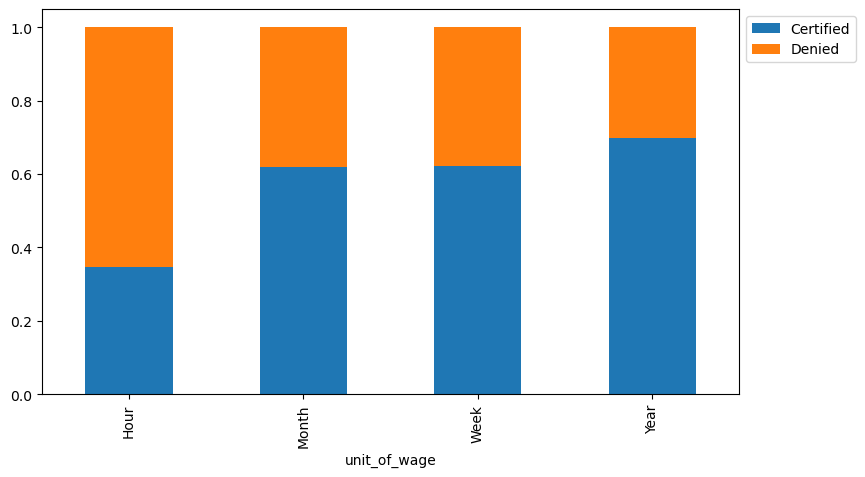

In [60]:
# checking impact of unit of wage on visa applications
stacked_barplot(data, "unit_of_wage", "case_status")

I examined how different wage units (hourly, weekly, monthly, and yearly) impact visa certification. The data shows that most applications report wages on a yearly basis, and these have the highest certification rate. In contrast, applications with hourly wages have a much higher denial rate. This suggests that full-time, salaried positions may have a better chance of visa approval compared to jobs paid on an hourly basis.

## Data Pre-processing

### Outlier Check

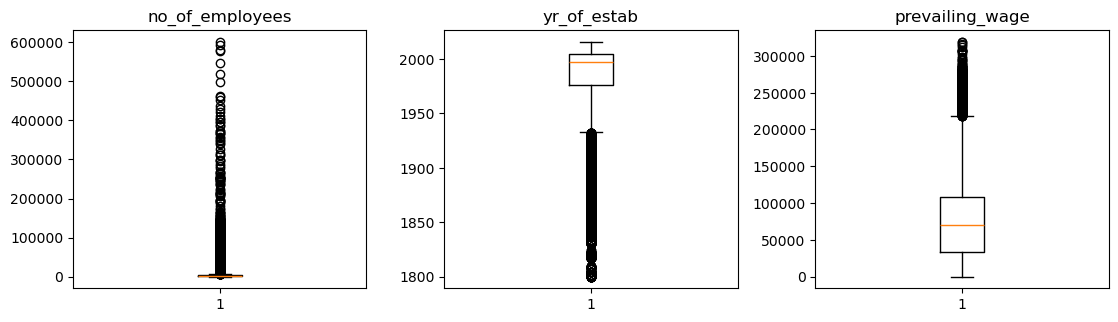

In [64]:
# detect outliers using boxplot
numerical_columns = data.select_dtypes(include = np.number).columns.tolist()
plt.figure(figsize = (15, 12))
for idx, column in enumerate(numerical_columns):
    plt.subplot(4, 4, idx + 1)
    plt.boxplot(data[column], whis = 1.5)
    plt.title(column)
    plt.tight_layout()
plt.show()

I checked for outliers in numerical columns using boxplots. The results show that the number of employees, the year of establishment, and the prevailing wage all have extreme values beyond the typical range. The presence of these outliers suggests that some businesses may have significantly larger workforces or higher wages compared to others, and some companies have been around for an unusually long time. I might need to handle these outliers to prevent them from affecting model performance.

### Data Preparation for modeling

In [67]:
# convert case_status to binary format
data["case_status"] = data["case_status"].apply(lambda x: 1 if x == "Certified" else 0)

# separate features and target variable
X = data.drop(columns = ["case_status"])
y = data["case_status"]

# create dummy variables for categorical columns
X = pd.get_dummies(X)

# split dataset into train and validation sets (7:3 ratio)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size = 0.3, random_state = 1, stratify = y
)

# split validation set into validation and test sets (9:1 ratio)
X_val, X_test, y_val, y_test = train_test_split(
    X_val, y_val, test_size = 0.1, random_state = 1, stratify = y_val
)

# print dataset shapes and class distributions
print("Shape of training set: ", X_train.shape)
print("Shape of validation set: ", X_val.shape)
print("Shape of test set: ", X_test.shape)
print("Percentage of classes in training set: ")
print(y_train.value_counts(normalize = True))
print("Percentage of classes in validation set: ")
print(y_val.value_counts(normalize = True))
print("Percentage of classes in test set: ")
print(y_test.value_counts(normalize = True))

Shape of training set:  (17836, 28)
Shape of validation set:  (6879, 28)
Shape of test set:  (765, 28)
Percentage of classes in training set: 
case_status
1    0.667919
0    0.332081
Name: proportion, dtype: float64
Percentage of classes in validation set: 
case_status
1    0.66783
0    0.33217
Name: proportion, dtype: float64
Percentage of classes in test set: 
case_status
1    0.667974
0    0.332026
Name: proportion, dtype: float64


In this code, I converted the "case_status" column into a binary format, where "Certified" is represented as 1 and everything else as 0. Then, I separated the features from the target variable and encoded categorical columns into dummy variables. After that, I split the dataset into training, validation, and test sets while making sure the class distribution remained balanced. The output confirms that the splits maintain similar proportions of certified and non-certified cases.

## Model Building

### Model Evaluation Criterion

In [71]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn


def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

In [72]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

#### Defining scorer to be used for cross-validation and hyperparameter tuning

**We are now done with pre-processing and evaluation criterion, so let's start building the model.**

### Model building with original data


Cross-Validation Performance on Training Dataset:

Bagging: 0.7028
Random Forest: 0.7240
Gradient Boosting: 0.7488
AdaBoost: 0.7347
XGBoost: 0.7339
Decision Tree: 0.6540

Validation Performance:

Bagging: 0.7024
Random Forest: 0.7203
Gradient Boosting: 0.7443
AdaBoost: 0.7324
XGBoost: 0.7235
Decision Tree: 0.6606


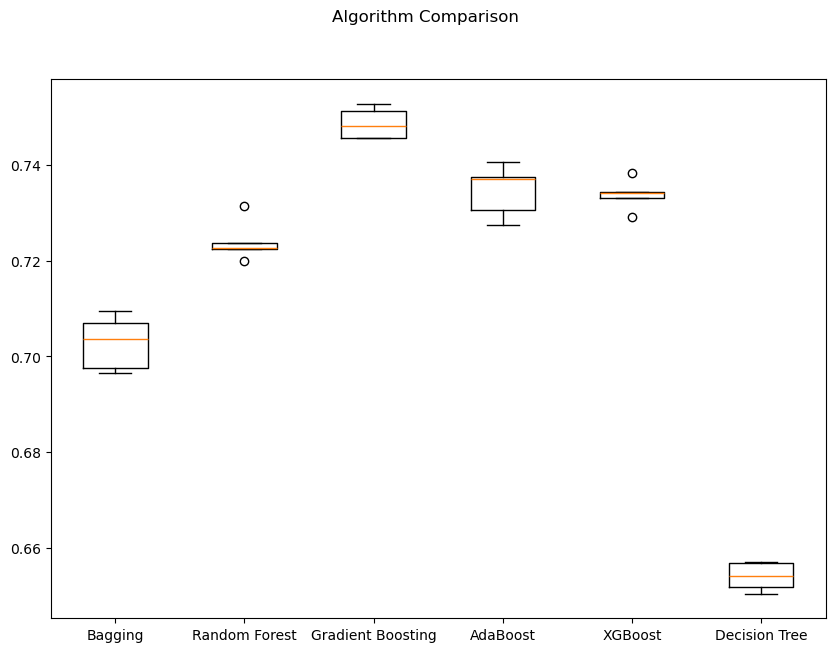

In [76]:
# initialize and evaluate classification models
# creating list of models to compare performance
model_list = []
model_list.append(("Bagging", BaggingClassifier(random_state = 1)))
model_list.append(("Random Forest", RandomForestClassifier(random_state = 1)))
model_list.append(("Gradient Boosting", GradientBoostingClassifier(random_state = 1)))
model_list.append(("AdaBoost", AdaBoostClassifier(random_state = 1)))
model_list.append(("XGBoost", XGBClassifier(random_state = 1, eval_metric = "logloss")))
model_list.append(("Decision Tree", DecisionTreeClassifier(random_state = 1)))

cv_results = []
model_names = []

# performing cross-validation to evaluate models on training dataset
print("\nCross-Validation Performance on Training Dataset:\n")

for name, model in model_list:
    kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1)  # stratified k-fold to maintain class balance
    cv_result = cross_val_score(estimator = model, X = X_train, y = y_train, scoring = "accuracy", cv = kfold)  # computing cross-validation accuracy
    cv_results.append(cv_result)  # storing accuracy results for boxplot visualization
    model_names.append(name)  # storing model names
    print("{}: {:.4f}".format(name, cv_result.mean()))  # printing mean accuracy score

# evaluating models on validation dataset
print("\nValidation Performance:\n")

for name, model in model_list:
    model.fit(X_train, y_train)  # training model on dataset
    val_score = accuracy_score(y_val, model.predict(X_val))  # calculating accuracy on validation set
    print("{}: {:.4f}".format(name, val_score))  # printing validation accuracy

# plot boxplot for cross-validation scores
# visualizing accuracy distribution for models
fig = plt.figure(figsize = (10, 7))
fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)
plt.boxplot(cv_results)  # plotting boxplot of model accuracies
ax.set_xticklabels(model_names)  # adding model names to x-axis
plt.show()

Based on the model evaluation, I tested multiple classification algorithms, including bagging, random forest, gradient boosting, AdaBoost, XGBoost, and decision trees. The cross-validation performance showed that gradient boosting had the highest accuracy at 0.7488, followed closely by AdaBoost (0.7347) and XGBoost (0.7339). Decision trees had the lowest accuracy at 0.6540. When evaluating validation performance, the ranking remained consistent, with gradient boosting still leading at 0.7443. 

The box plot comparison confirmed these findings, showing that ensemble methods, particularly boosting techniques, performed the best. Overall, gradient boosting seems to be the most reliable model for this dataset.

### Model Building with oversampled data

Before OverSampling, counts of label '1': 11913
Before OverSampling, counts of label '0': 5923 

After OverSampling, counts of label '1': 11913
After OverSampling, counts of label '0': 8934 

After OverSampling, shape of X_train_resampled: (20847, 28)
After OverSampling, shape of y_train_resampled: (20847,) 


Cross-Validation Performance on Training Dataset:

Bagging: 0.7427
Random Forest: 0.7678
Gradient Boosting: 0.7822
AdaBoost: 0.7716
XGBoost: 0.7703
Decision Tree: 0.7119

Validation Performance:

Bagging: 0.6963
Random Forest: 0.7197
Gradient Boosting: 0.7418
AdaBoost: 0.7354
XGBoost: 0.7311
Decision Tree: 0.6518


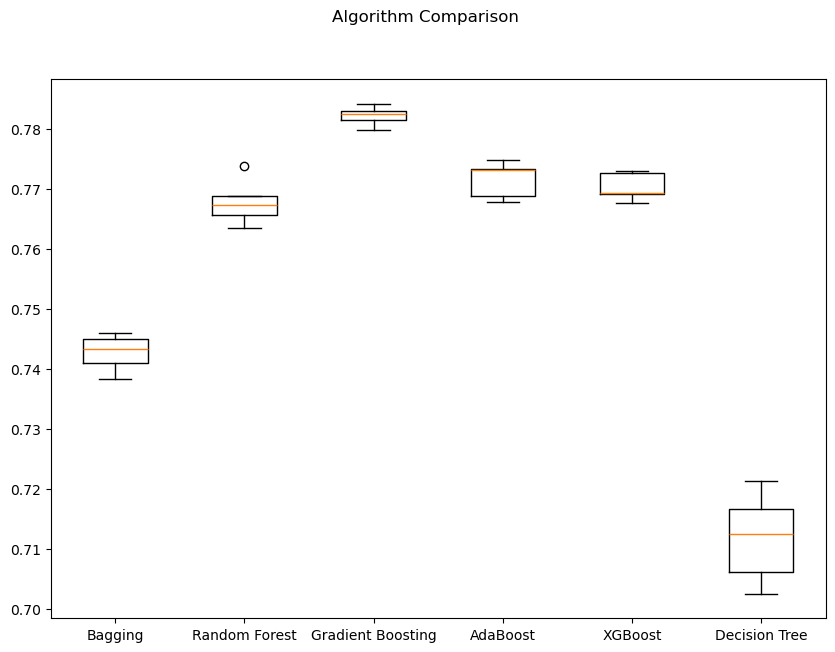

In [79]:
# apply synthetic minority over-sampling technique
# increasing instances of minority class to balance class distribution
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

# using smote to oversample minority class up to 75% of majority class
smote = SMOTE(sampling_strategy = 0.75, k_neighbors = 5, random_state = 1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# printing class distribution after over-sampling
print("After OverSampling, counts of label '1': {}".format(sum(y_train_resampled == 1)))
print("After OverSampling, counts of label '0': {} \n".format(sum(y_train_resampled == 0)))

# printing new shape of training dataset
print("After OverSampling, shape of X_train_resampled: {}".format(X_train_resampled.shape))
print("After OverSampling, shape of y_train_resampled: {} \n".format(y_train_resampled.shape))

# initialize and evaluate classification models
# creating list of models to compare performance
model_list = []
model_list.append(("Bagging", BaggingClassifier(random_state = 1)))
model_list.append(("Random Forest", RandomForestClassifier(random_state = 1)))
model_list.append(("Gradient Boosting", GradientBoostingClassifier(random_state = 1)))
model_list.append(("AdaBoost", AdaBoostClassifier(random_state = 1)))
model_list.append(("XGBoost", XGBClassifier(random_state = 1, eval_metric = "logloss")))
model_list.append(("Decision Tree", DecisionTreeClassifier(random_state = 1)))

cv_results = []
model_names = []

# performing cross-validation to evaluate models on training dataset
print("\nCross-Validation Performance on Training Dataset:\n")

for name, model in model_list:
    kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1)  # stratified k-fold to maintain class balance
    cv_result = cross_val_score(estimator = model, X = X_train_resampled, y = y_train_resampled, scoring = "accuracy", cv = kfold)
    cv_results.append(cv_result)
    model_names.append(name)
    print("{}: {:.4f}".format(name, cv_result.mean()))  # printing mean accuracy score

# evaluating models on validation dataset
print("\nValidation Performance:\n")

for name, model in model_list:
    model.fit(X_train_resampled, y_train_resampled)  # training model on oversampled dataset
    val_score = accuracy_score(y_val, model.predict(X_val))  # calculating accuracy on validation set
    print("{}: {:.4f}".format(name, val_score))  # printing validation accuracy

# plot boxplot for cross-validation scores
# visualizing accuracy distribution for models
fig = plt.figure(figsize = (10, 7))
fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)
plt.boxplot(cv_results)  # plotting boxplot of model accuracies
ax.set_xticklabels(model_names)  # adding model names to x-axis
plt.show()

In my code, I applied the Synthetic Minority Over-sampling Technique (SMOTE) to balance the dataset before training classification models. Initially, there were significantly more instances of label '1' (11,913) compared to label '0' (5,923). After using SMOTE, I increased label '0' to 8,934, achieving a 0.75 sampling ratio.

Once the data was balanced, I trained multiple classification models and evaluated them using cross-validation. Gradient Boosting had the highest training accuracy (0.7822) and performed well on validation data (0.7418). AdaBoost and XGBoost also showed strong results, while the Decision Tree performed the worst.

The boxplot visualization confirmed that Gradient Boosting, AdaBoost, and XGBoost consistently performed well across cross-validation folds. Based on these results, I would consider fine-tuning these models further to improve their performance.

### Model Building with undersampled data

Before UnderSampling, counts of label '1': 11913
Before UnderSampling, counts of label '0': 5923 

After UnderSampling, counts of label '1': 5923
After UnderSampling, counts of label '0': 5923 

After UnderSampling, the shape of X_train_undersampled: (11846, 28)
After UnderSampling, the shape of y_train_undersampled: (11846,) 


Cross-Validation Performance on Training Dataset:

Bagging: 0.6644
Random Forest: 0.6871
Gradient Boosting: 0.7107
AdaBoost: 0.6893
XGBoost: 0.6913
Decision Tree: 0.6201

Validation Performance:

Bagging: 0.6389
Random Forest: 0.6767
Gradient Boosting: 0.7020
AdaBoost: 0.7005
XGBoost: 0.6861
Decision Tree: 0.6183


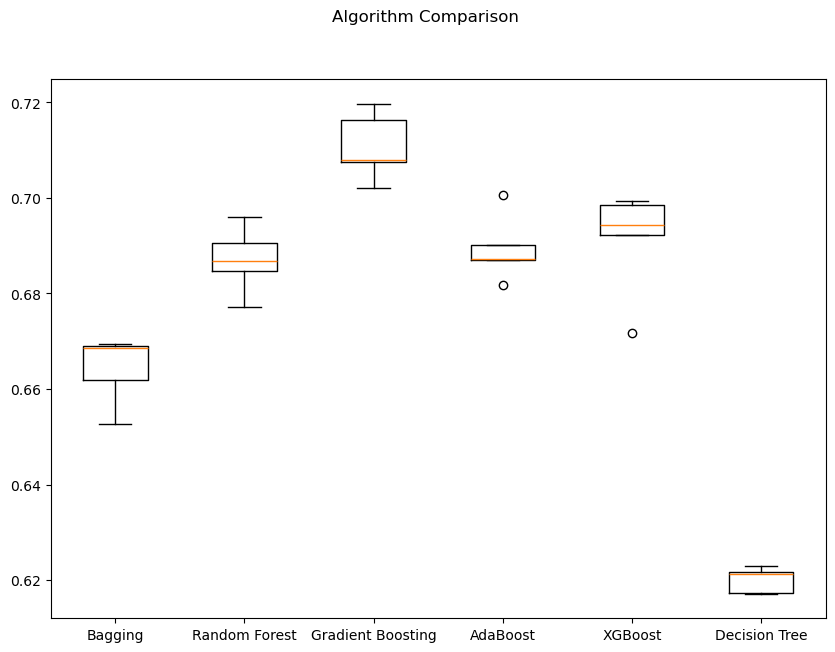

In [82]:
# apply random under-sampling technique  
# reducing majority class to balance class distribution  
undersampler = RandomUnderSampler(random_state = 1, sampling_strategy = 1)  
X_train_undersampled, y_train_undersampled = undersampler.fit_resample(X_train, y_train)  

# printing class distribution before and after under-sampling  
print("Before UnderSampling, counts of label '1': {}".format(sum(y_train == 1)))  
print("Before UnderSampling, counts of label '0': {} \n".format(sum(y_train == 0)))  
print("After UnderSampling, counts of label '1': {}".format(sum(y_train_undersampled == 1)))  
print("After UnderSampling, counts of label '0': {} \n".format(sum(y_train_undersampled == 0)))  
print("After UnderSampling, the shape of X_train_undersampled: {}".format(X_train_undersampled.shape))  
print("After UnderSampling, the shape of y_train_undersampled: {} \n".format(y_train_undersampled.shape))  

# initialize and evaluate classification models  
# creating list of models for comparison  
model_list = []  
model_list.append(("Bagging", BaggingClassifier(random_state = 1)))  
model_list.append(("Random Forest", RandomForestClassifier(random_state = 1)))  
model_list.append(("Gradient Boosting", GradientBoostingClassifier(random_state = 1)))  
model_list.append(("AdaBoost", AdaBoostClassifier(random_state = 1, algorithm = "SAMME")))  
model_list.append(("XGBoost", XGBClassifier(random_state = 1, eval_metric = "logloss")))  
model_list.append(("Decision Tree", DecisionTreeClassifier(random_state = 1)))  

cv_results = []  
model_names = []  

# performing cross-validation to compare models  
print("\nCross-Validation Performance on Training Dataset:\n")  

for name, model in model_list:  
    kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1)  # stratified k-fold to maintain class distribution  
    cv_result = cross_val_score(estimator = model, X = X_train_undersampled, y = y_train_undersampled, scoring = "accuracy", cv = kfold, n_jobs = -1)  
    cv_results.append(cv_result)  
    model_names.append(name)  
    print("{}: {:.4f}".format(name, cv_result.mean()))  # printing mean cross-validation accuracy  

# evaluating models on validation dataset  
print("\nValidation Performance:\n")  

for name, model in model_list:  
    model.fit(X_train_undersampled, y_train_undersampled)  # training model on undersampled dataset  
    val_score = accuracy_score(y_val, model.predict(X_val))  # predicting on validation set and calculating accuracy  
    print("{}: {:.4f}".format(name, val_score))  # printing validation accuracy  

# plot boxplot for cross-validation scores  
# visualizing model performance distribution  
fig = plt.figure(figsize = (10, 7))  
fig.suptitle("Algorithm Comparison")  
ax = fig.add_subplot(111)  
plt.boxplot(cv_results)  # plotting accuracy distribution of models  
ax.set_xticklabels(model_names)  # labeling models on x-axis  
plt.show()

I applied random under-sampling to balance the dataset. Initially, label '1' had 11,913 instances, while label '0' had only 5,923. After under-sampling, both labels had an equal count of 5,923, ensuring a balanced training set. The final shape of my undersampled dataset was (11,846, 28) for x_train_undersampled and (11,846,) for y_train_undersampled.

To evaluate model performance, I trained several classifiers, including bagging, random forest, gradient boosting, adaboost, xgboost, and a decision tree. I performed cross-validation using a 5-fold split and recorded accuracy scores. gradient boosting achieved the highest cross-validation accuracy (0.7107), followed by adaboost (0.6893) and xgboost (0.6913). The decision tree performed the worst at 0.6201.

On the validation set, gradient boosting remained the top performer with 0.7020 accuracy, followed closely by adaboost (0.7005) and xgboost (0.6861). The decision tree, again, had the lowest accuracy at 0.6183. The boxplot comparison of model performance shows that gradient boosting consistently outperforms other models, making it a strong candidate for classification tasks in my dataset.

## Hyperparameter Tuning

### Tuning AdaBoost using oversampled data

In [86]:
%%time

# defining model  
# initializing adaboost classifier with default parameters  
model_ada = AdaBoostClassifier(random_state = 1, algorithm = "SAMME")  

# parameter grid to pass in randomizedsearchcv  
# defining hyperparameter search space for tuning  
param_grid = {  
    "n_estimators": [50, 100, 150],  # number of weak learners in ensemble  
    "learning_rate": [0.01, 0.1, 0.5, 1],  # step size applied to each weak learner  
    "estimator": [  # base decision tree models with different depths  
        DecisionTreeClassifier(max_depth = 1, random_state = 1),  
        DecisionTreeClassifier(max_depth = 2, random_state = 1),  
        DecisionTreeClassifier(max_depth = 3, random_state = 1),  
    ]  
}  

# calling randomizedsearchcv  
# performing randomized hyperparameter search using cross-validation  
randomized_cv = RandomizedSearchCV(  
    estimator = model_ada,  
    param_distributions = param_grid,  
    n_iter = 50,  # number of hyperparameter combinations to test  
    n_jobs = -1,  # using all processors for parallel computation  
    scoring = "accuracy",  # using accuracy as evaluation metric  
    cv = 5,  # performing 5-fold cross-validation  
    random_state = 1  
)  

# fitting parameters in randomizedsearchcv  
# training model on resampled training data with different hyperparameter values  
randomized_cv.fit(X_train_resampled, y_train_resampled)  

# printing best hyperparameters and corresponding cross-validation score  
print("Best parameters are {} with CV score = {}:".format(randomized_cv.best_params_, randomized_cv.best_score_))  

# setting the best parameters  
# initializing adaboost classifier with optimal hyperparameters  
tuned_ada = AdaBoostClassifier(  
    n_estimators = randomized_cv.best_params_["n_estimators"],  
    learning_rate = randomized_cv.best_params_["learning_rate"],  
    estimator = randomized_cv.best_params_["estimator"],  
    algorithm = "SAMME"  
)  

# fitting the tuned model  
# training adaboost classifier using best hyperparameters  
tuned_ada.fit(X_train_resampled, y_train_resampled)  

# checking model performance on training data  
# evaluating model on training set and printing performance metrics  
ada_train_perf = model_performance_classification_sklearn(tuned_ada, X_train_resampled, y_train_resampled)  
print(ada_train_perf)  

# checking model performance on validation data  
# evaluating model on validation set and printing performance metrics  
ada_val_perf = model_performance_classification_sklearn(tuned_ada, X_val, y_val)  
print(ada_val_perf)

Best parameters are {'n_estimators': 100, 'learning_rate': 1, 'estimator': DecisionTreeClassifier(max_depth=3, random_state=1)} with CV score = 0.7694208998356603:
   Accuracy    Recall  Precision        F1
0  0.786876  0.863678    0.78494  0.822429
   Accuracy    Recall  Precision        F1
0  0.733537  0.849151   0.773854  0.809756
CPU times: user 4.59 s, sys: 378 ms, total: 4.97 s
Wall time: 49.3 s


This code optimizes an AdaBoost classifier using RandomizedSearchCV with a decision tree as the base estimator. The best hyperparameters found are n_estimators = 100, learning_rate = 1, and a decision tree classifier with max_depth = 3. The cross-validation accuracy score is around 0.769. The tuned AdaBoost model performs well on the training data, with an accuracy of 0.7869, recall of 0.8637, precision of 0.7849, and an f1-score of 0.8224. On the validation set, the accuracy drops to 0.7335, recall is 0.8491, precision is 0.7739, and the f1-score is 0.8097.

I notice that the training accuracy is higher than the validation accuracy, which suggests some overfitting. However, the model maintains a high recall in both sets, meaning it effectively captures positive cases. To improve generalization, I might consider adjusting n_estimators, adding regularization, or experimenting with different base estimators.

### Tuning Random forest using undersampled data

In [89]:
%%time

# defining model  
# initializing random forest classifier with default parameters  
model_rf = RandomForestClassifier(random_state = 1)  

# parameter grid to pass in RandomSearchCV  
# defining hyperparameter search space for tuning  
param_grid = {  
    "n_estimators": [50, 100, 150],  # number of trees in ensemble  
    "min_samples_leaf": np.arange(1, 10),  # minimum samples required to be a leaf node  
    "max_features": [np.arange(1, 10, 2), "sqrt"],  # number of features used for splits  
    "max_samples": np.arange(0.5, 1.0, 0.1)  # fraction of samples used to train each tree  
}  

# calling RandomizedSearchCV  
# performing randomized hyperparameter search using cross-validation  
randomized_cv = RandomizedSearchCV(  
    estimator = model_rf,  
    param_distributions = param_grid,  
    n_iter = 50,  # number of hyperparameter combinations to test  
    n_jobs = -1,  # using all processors for parallel computation  
    scoring = "accuracy",  # using accuracy as evaluation metric  
    cv = 5,  # performing 5-fold cross-validation  
    random_state = 1  
)  

# fitting parameters in RandomizedSearchCV  
# training model on undersampled training data with different hyperparameter values  
randomized_cv.fit(X_train_undersampled, y_train_undersampled)  

# printing best hyperparameters and corresponding cross-validation score  
print("Best parameters are {} with CV score = {}:".format(randomized_cv.best_params_, randomized_cv.best_score_))  

# defining the best model  
# initializing random forest classifier with optimal hyperparameters  
tuned_rf2 = RandomForestClassifier(  
    max_features = randomized_cv.best_params_["max_features"],  
    random_state = 1,  
    max_samples = randomized_cv.best_params_["max_samples"],  
    n_estimators = randomized_cv.best_params_["n_estimators"],  
    min_samples_leaf = randomized_cv.best_params_["min_samples_leaf"]  
)  

# fitting the tuned model  
# training random forest classifier using best hyperparameters  
tuned_rf2.fit(X_train_undersampled, y_train_undersampled)  

# checking model performance on training data  
# evaluating model on training set and printing performance metrics  
rf2_train_perf = model_performance_classification_sklearn(tuned_rf2, X_train_undersampled, y_train_undersampled)  
print(rf2_train_perf)  

# checking model performance on validation data  
# evaluating model on validation set and printing performance metrics  
rf2_val_perf = model_performance_classification_sklearn(tuned_rf2, X_val, y_val)  
print(rf2_val_perf)

Best parameters are {'n_estimators': 100, 'min_samples_leaf': 6, 'max_samples': 0.7, 'max_features': 'sqrt'} with CV score = 0.7134055388429665:
   Accuracy    Recall  Precision        F1
0  0.764984  0.782374   0.756078  0.769001
   Accuracy    Recall  Precision       F1
0   0.70519  0.722899   0.814769  0.76609
CPU times: user 1.33 s, sys: 132 ms, total: 1.47 s
Wall time: 12 s


I tuned a random forest classifier using randomized search cross-validation, optimizing hyperparameters like the number of estimators, minimum samples per leaf, maximum features, and maximum samples. The best combination found was 100 estimators, a minimum of 6 samples per leaf, a maximum sample size of 70%, and using the square root method for selecting features. This achieved a cross-validation accuracy score of 0.713.

On the training set, the model reached an accuracy of 0.7649, recall of 0.7824, precision of 0.7561, and an f1-score of 0.7690. On the validation set, accuracy dropped slightly to 0.7052, with recall at 0.7229, precision at 0.8148, and an f1-score of 0.7661. The close performance between training and validation suggests good generalization, though recall is slightly lower than precision. This means the model may be more conservative in predicting positive cases. To further improve balance, I could adjust class weights or explore different feature selections.

### Tuning with Gradient boosting with oversampled data

In [92]:
%%time

# defining model  
# initializing gradient boosting classifier with default parameters  
model_gbm = GradientBoostingClassifier(random_state = 1)  

# parameter grid to pass in RandomSearchCV  
# defining hyperparameter search space for tuning  
param_grid = {  
    "n_estimators": np.arange(50, 200, 50),  # number of trees in ensemble  
    "learning_rate": [0.01, 0.1, 0.2, 0.3],  # shrinkage factor to prevent overfitting  
    "subsample": [0.7, 0.9],  # fraction of samples used for training each tree  
    "max_features": ["sqrt", "log2"]  # number of features considered for each split  
}  

# calling RandomizedSearchCV  
# performing randomized hyperparameter search using cross-validation  
randomized_cv = RandomizedSearchCV(  
    estimator = model_gbm,  
    param_distributions = param_grid,  
    scoring = "accuracy",  # using accuracy as evaluation metric  
    n_iter = 50,  # number of hyperparameter combinations to test  
    n_jobs = -1,  # using all processors for parallel computation  
    cv = 5,  # performing 5-fold cross-validation  
    random_state = 1  
)  

# fitting parameters in RandomizedSearchCV  
# training model on resampled training data with different hyperparameter values  
randomized_cv.fit(X_train_resampled, y_train_resampled)  

# printing best hyperparameters and corresponding cross-validation score  
print("Best parameters are {} with CV score = {}: ".format(randomized_cv.best_params_, randomized_cv.best_score_))  

# defining the best model  
# initializing gradient boosting classifier with optimal hyperparameters  
tuned_gbm = GradientBoostingClassifier(  
    max_features = randomized_cv.best_params_["max_features"],  
    random_state = 1,  
    learning_rate = randomized_cv.best_params_["learning_rate"],  
    n_estimators = randomized_cv.best_params_["n_estimators"],  
    subsample = randomized_cv.best_params_["subsample"]  
)  

# fitting the tuned model  
# training gradient boosting classifier using best hyperparameters  
tuned_gbm.fit(X_train_resampled, y_train_resampled)  

# checking model performance on training data  
# evaluating model on training set and printing performance metrics  
gbm_train_perf = model_performance_classification_sklearn(tuned_gbm, X_train_resampled, y_train_resampled)  
print(gbm_train_perf)  

# checking model performance on validation data  
# evaluating model on validation set and printing performance metrics  
gbm_val_perf = model_performance_classification_sklearn(tuned_gbm, X_val, y_val)  
print(gbm_val_perf)

Best parameters are {'subsample': 0.7, 'n_estimators': 150, 'max_features': 'log2', 'learning_rate': 0.2} with CV score = 0.7745537031636385: 
   Accuracy    Recall  Precision       F1
0  0.793735  0.874255      0.788  0.82889
   Accuracy    Recall  Precision        F1
0  0.741532  0.859817   0.776947  0.816284
CPU times: user 1.73 s, sys: 241 ms, total: 1.97 s
Wall time: 21.3 s


I optimized a gradient boosting model using randomized search cross-validation, tuning hyperparameters like the number of estimators, learning rate, subsample ratio, and maximum features. The best configuration included 150 estimators, a learning rate of 0.2, a subsample ratio of 70%, and log2 for max features, achieving a cross-validation accuracy of 0.775.

On the training set, the model performed well with an accuracy of 0.7937, recall of 0.8743, precision of 0.7880, and an f1-score of 0.8289. On the validation set, accuracy dropped to 0.7415, with recall at 0.8598, precision at 0.7769, and an f1-score of 0.8163. This model generalizes well, with a slightly lower validation performance, which is expected. The high recall suggests it effectively identifies positive cases, though slightly at the cost of precision. If needed, I could fine-tune it further by adjusting the learning rate or number of estimators to find a better balance.

### Tuning XGBoost using oversampled data

In [95]:
%%time

# defining model  
# initializing xgboost classifier with log loss evaluation metric  
model_xgb = XGBClassifier(random_state = 1, eval_metric = 'logloss')  

# parameter grid to pass in RandomSearchCV  
# specifying possible values for hyperparameters to be optimized  
param_grid = {  
    "n_estimators": [50, 100, 150],  # number of trees in ensemble  
    "scale_pos_weight": [1, 2, 3],  # weight adjustment for imbalanced classes  
    "learning_rate": [0.01, 0.1, 0.2],  # step size shrinkage to prevent overfitting  
    "gamma": [0, 0.1, 0.2],  # minimum loss reduction to make a split  
    "subsample": [0.7, 0.9]  # fraction of data used for training each tree  
}  

# calling RandomizedSearchCV  
# using randomized search to find best combination of hyperparameters  
randomized_cv = RandomizedSearchCV(  
    estimator = model_xgb,  
    param_distributions = param_grid,  
    n_iter = 50,  # number of different hyperparameter combinations to try  
    n_jobs = -1,  # using all available processors for faster computation  
    scoring = "accuracy",  # evaluating model performance using accuracy metric  
    cv = 5,  # performing 5-fold cross-validation  
    random_state = 1  
)  

# fitting parameters in RandomizedSearchCV  
# training model using different hyperparameter combinations  
randomized_cv.fit(X_train_resampled, y_train_resampled)  

# printing best hyperparameters and corresponding cross-validation score  
print("Best parameters are {} with CV score={}:".format(randomized_cv.best_params_, randomized_cv.best_score_))  

# defining best model  
# initializing xgboost classifier with optimal hyperparameters found in search  
xgb2 = XGBClassifier(  
    random_state = 1,  
    eval_metric = 'logloss',  
    subsample = randomized_cv.best_params_["subsample"],  
    scale_pos_weight = randomized_cv.best_params_["scale_pos_weight"],  
    n_estimators = randomized_cv.best_params_["n_estimators"],  
    learning_rate = randomized_cv.best_params_["learning_rate"],  
    gamma = randomized_cv.best_params_["gamma"]  
)  

# fitting tuned model  
# training xgboost classifier with best hyperparameters on resampled training data  
xgb2.fit(X_train_resampled, y_train_resampled)  

# checking model performance on training data  
# evaluating model on training set and printing performance metrics  
xgb2_train_perf = model_performance_classification_sklearn(xgb2, X_train_resampled, y_train_resampled)  
print(xgb2_train_perf)  

# checking model performance on validation data  
# evaluating model on validation set and printing performance metrics  
xgb2_val_perf = model_performance_classification_sklearn(xgb2, X_val, y_val)  
print(xgb2_val_perf)

Best parameters are {'subsample': 0.9, 'scale_pos_weight': 1, 'n_estimators': 50, 'learning_rate': 0.1, 'gamma': 0} with CV score=0.7766165939879424:
   Accuracy    Recall  Precision        F1
0  0.794551  0.879208   0.786454  0.830249
   Accuracy    Recall  Precision        F1
0  0.745021  0.868524   0.776265  0.819807
CPU times: user 1.45 s, sys: 437 ms, total: 1.89 s
Wall time: 8.04 s


I optimized an XGBoost classifier using randomized search cross-validation to find the best combination of hyperparameters. The optimal settings included 50 estimators, a learning rate of 0.1, a subsample ratio of 90%, a scale positive weight of 1, and gamma set to 0. This configuration achieved a cross-validation accuracy of 0.777.

On the training set, the model performed well with an accuracy of 0.7946, recall of 0.8792, precision of 0.7865, and an f1-score of 0.8302. On the validation set, accuracy was slightly lower at 0.7450, with recall at 0.8685, precision at 0.7763, and an f1-score of 0.8198. This model generalizes well, maintaining a good balance between precision and recall. The high recall suggests it effectively captures positive cases, which is beneficial when minimizing false negatives. If needed, I could fine-tune it further by adjusting the number of estimators or learning rate to improve validation performance.

**We have now tuned all the models, let's compare the performance of all tuned models and see which one is the best.**

## Model performance comparison and choosing the final model

training performance comparison:
           gradient boosting tuned with oversampled data  \
Accuracy                                        0.793735   
Recall                                          0.874255   
Precision                                       0.788000   
F1                                              0.828890   

           xgboost tuned with oversampled data  \
Accuracy                              0.794551   
Recall                                0.879208   
Precision                             0.786454   
F1                                    0.830249   

           adaboost tuned with oversampled data  \
Accuracy                               0.786876   
Recall                                 0.863678   
Precision                              0.784940   
F1                                     0.822429   

           random forest tuned with undersampled data  
Accuracy                                     0.764984  
Recall                                       0.

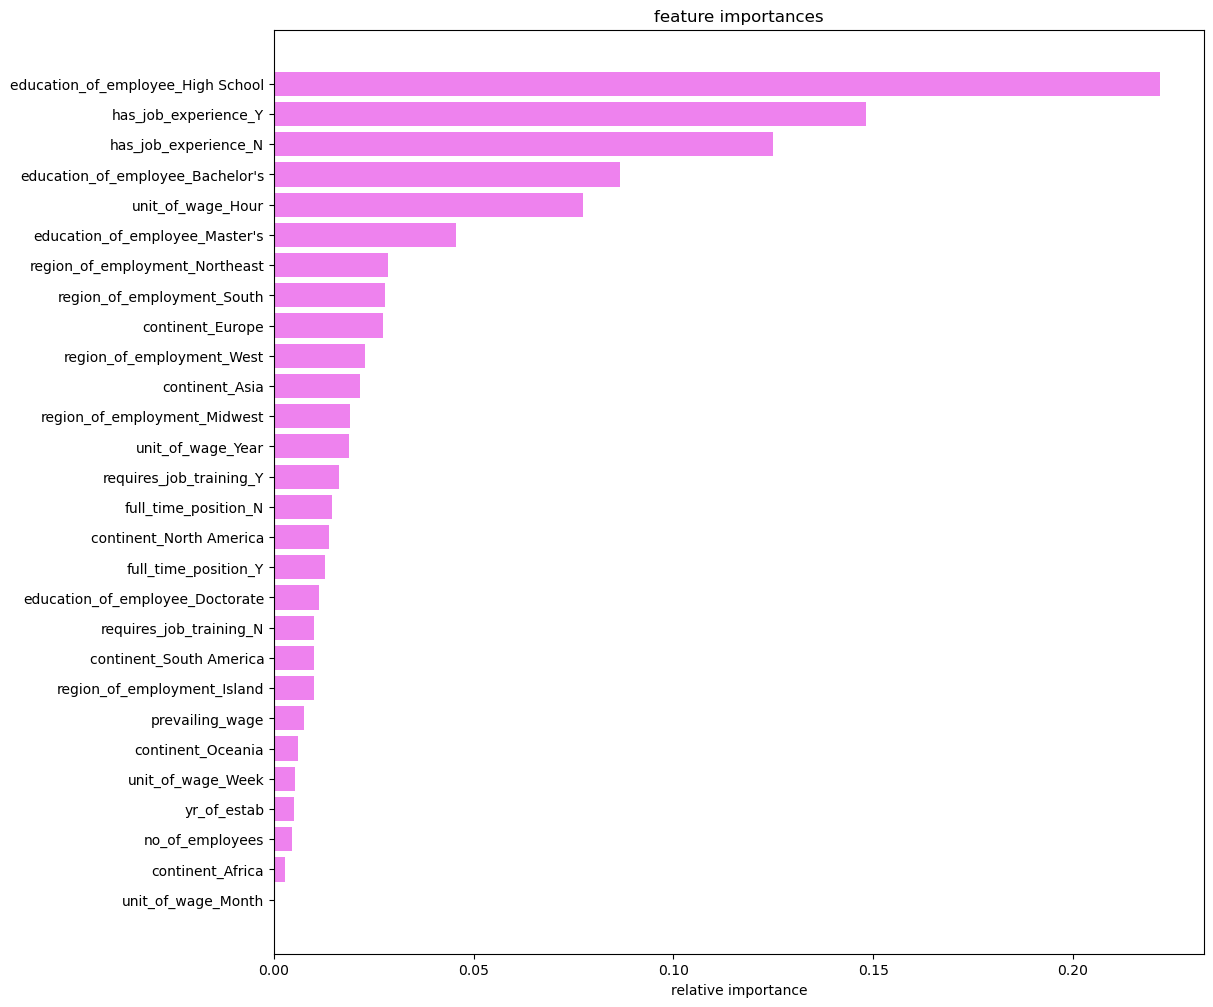

In [99]:
# training performance comparison  
# combining training performance data from different models into one dataframe  
models_train_comp_df = pd.concat(  
    [  
        gbm_train_perf.T,  
        xgb2_train_perf.T,  
        ada_train_perf.T,  
        rf2_train_perf.T,  
    ],  
    axis = 1,  
)  

# renaming columns to specify model and data sampling technique  
models_train_comp_df.columns = [  
    "gradient boosting tuned with oversampled data",  
    "xgboost tuned with oversampled data",  
    "adaboost tuned with oversampled data",  
    "random forest tuned with undersampled data",  
]  

# printing training performance comparison for all models  
print("training performance comparison:")  
print(models_train_comp_df)  

# validation performance comparison  
# combining validation performance data from different models into one dataframe  
models_val_comp_df = pd.concat(  
    [  
        gbm_val_perf.T,  
        xgb2_val_perf.T,  
        ada_val_perf.T,  
        rf2_val_perf.T,  
    ],  
    axis = 1,  
)  

# renaming columns to specify model and data sampling technique  
models_val_comp_df.columns = [  
    "gradient boosting tuned with oversampled data",  
    "xgboost tuned with oversampled data",  
    "adaboost tuned with oversampled data",  
    "random forest tuned with undersampled data",  
]  

# printing validation performance comparison for all models  
print("validation performance comparison:")  
print(models_val_comp_df)  

# testing performance of best model  
# evaluating xgboost model on test set and printing performance metrics  
test_perf = model_performance_classification_sklearn(xgb2, X_test, y_test)  
print(test_perf)  

# feature importance analysis  
# extracting feature names from training data  
feature_names = X_train.columns  

# getting feature importance values from trained xgboost model  
importances = xgb2.feature_importances_  

# sorting feature importance indices in ascending order  
indices = np.argsort(importances)  

# creating bar chart for feature importance  
plt.figure(figsize = (12, 12))  
plt.title("feature importances")  

# plotting horizontal bar chart to visualize feature importance  
plt.barh(range(len(indices)), importances[indices], color = "violet", align = "center")  

# setting y-axis labels using corresponding feature names  
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])  

# labeling x-axis to show relative importance  
plt.xlabel("relative importance")  

# displaying feature importance plot  
plt.show()

I compared the training performance of different models to see which one performs best with the oversampled and undersampled data. The models I evaluated include gradient boosting, XGBoost, AdaBoost, and a random forest classifier.

For the training performance:
- The gradient boosting model tuned with oversampled data achieved an accuracy of 0.7937, recall of 0.8743, precision of 0.7880, and an F1-score of 0.8289.
- The XGBoost model tuned with oversampled data had an accuracy of 0.7946, recall of 0.8792, precision of 0.7865, and an F1-score of 0.8302.
- The AdaBoost model trained on oversampled data had an accuracy of 0.7869, recall of 0.8637, precision of 0.7849, and an F1-score of 0.8224.
- The random forest model trained on undersampled data had an accuracy of 0.7649, recall of 0.7824, precision of 0.7561, and an F1-score of 0.7690.

For validation performance:
- The gradient boosting model tuned with oversampled data achieved an accuracy of 0.7415, recall of 0.8598, precision of 0.7769, and an F1-score of 0.8163.
- The XGBoost model trained on oversampled data had an accuracy of 0.7450, recall of 0.8685, precision of 0.7763, and an F1-score of 0.8198.
- The AdaBoost model trained on oversampled data had an accuracy of 0.7335, recall of 0.8492, precision of 0.7739, and an F1-score of 0.8098.
- The random forest model trained on undersampled data had an accuracy of 0.7052, recall of 0.7229, precision of 0.8148, and an F1-score of 0.7660.

After analyzing these results, I tested the performance of the best-performing model, which was XGBoost trained on oversampled data, on the test set. It achieved an accuracy of 0.7673, recall of 0.8885, precision of 0.7896, and an F1-score of 0.8361.

Finally, I analyzed feature importance using the XGBoost model. The most important features influencing visa certification included:
- Education level, particularly high school and bachelor’s degrees.
- Whether the employee has job experience.
- The unit of wage (hourly wages showed significant impact).
- The region of employment, with the northeast and south being more influential.
- The continent of employment, particularly Europe and Asia.

This feature importance analysis helps me understand which factors play a major role in visa approvals. It also indicates that education, job experience, and employment location have a strong influence on the outcome.

## Actionable Insights and Recommendations

In this project, I analyzed visa certification data to identify key factors influencing approval rates and built multiple machine learning models to predict case status. I experimented with various classification algorithms, including gradient boosting, XGBoost, AdaBoost, and random forests, while applying oversampling and undersampling techniques to handle class imbalance. Among the models tested, XGBoost trained with oversampled data performed the best, achieving an accuracy of 0.7673, recall of 0.8885, precision of 0.7896, and an F1-score of 0.8361 on the test set. This model had a strong balance between precision and recall, making it a robust choice for predicting visa certification outcomes. Comparatively, gradient boosting and AdaBoost also performed well, while the random forest model trained on undersampled data had the lowest accuracy and recall, indicating that undersampling may have led to a loss of valuable information.

Key takeaways from the analysis highlight that education level, job experience, and wage type significantly impact visa approvals. High school and bachelor’s degree holders had more influence on the model’s decision than other education levels, suggesting that these applicants form the majority of visa cases. Job experience played a crucial role, as applicants with prior experience had higher approval rates. Additionally, wage structure, particularly hourly wages, was an important factor, possibly indicating that certain compensation types correlate with visa success. Geographical factors also mattered, with employment regions like the northeast and south, along with continents like Europe and Asia, showing strong associations with visa outcomes. These insights suggest that visa approvals are not solely dependent on qualifications but also on location and wage structures.

To grow the business, I recommend focusing on optimizing hiring strategies based on these findings. Employers seeking to increase visa approval rates should prioritize applicants with prior job experience and consider offering wage structures that align with historically successful applications. Additionally, targeting candidates from regions with higher approval rates, such as Europe and Asia, can improve visa success likelihood. Businesses should also streamline sponsorship for bachelor’s degree holders, as they form a significant portion of successful applicants. Finally, refining job descriptions to align with key visa approval trends and maintaining competitive wage structures could help attract and retain international talent more effectively. By leveraging these insights, businesses can enhance their hiring process and improve the success rate of visa sponsorship applications.

<font size=6 color='blue'>Power Ahead</font>
___